In [10]:
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import cv2  # computer vision algorithms
from keras import utils
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from tqdm import tqdm  # Progress bar and status logging
import shutil  # high-level operations on files
import os
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np  # linear algebra
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout,\
GlobalMaxPooling2D, GlobalAveragePooling2D, MaxPooling2D,BatchNormalization,Add, Activation
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
from tensorflow.keras.applications.vgg16 import VGG16 ,  preprocess_input
from tensorflow import keras
from  IPython import display
from matplotlib import pyplot as plt

In [11]:
def get_images(path, img_shape):
    '''
    Returns a np array of images and labels from path
    '''
    main_path = path
    y = []
    list = [name for name in os.listdir(main_path) 
            if os.path.isdir(os.path.join(main_path, name))]
    print(list)
    image_collection = []
    for idx, folder in enumerate(list):
        label = idx
        sub_list = sorted(os.listdir(os.path.join(main_path, folder)))
        for i in tqdm(range(1, len(sub_list))):
            image_path = os.path.join(main_path, folder, sub_list[i])
            read_image = cv2.imread(image_path)
            image_resized = cv2.resize(read_image, img_shape, interpolation=cv2.INTER_AREA)
            image = np.float32(image_resized)
            image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX,
                                  dtype=cv2.CV_32F)  
            image_collection.append(image)
            y.append(label)
    y = np.array(y)
    y = utils.to_categorical(y, num_classes=len(list))
    return image_collection, y[:, 0]

In [ ]:
"""Preprocessing and loading images"""
DATASET_DIR = 'Data/real_and_fake_face/real_and_fake_face'
TRAIN_DIR = 'Data/real_and_fake_face/real_and_fake_face/train_dataset'
TEST_DIR = 'Data/real_and_fake_face/real_and_fake_face/test_dataset'
image_path = 'real_and_fake_face/train_dataset/fake/easy_1_1110.jpg'
read_image = cv2.imread(image_path)
X_train,y_train = get_images(TRAIN_DIR,img_shape=(128,128))
X_test,y_test = get_images(TEST_DIR,img_shape=(128,128))
X_train = np.array(X_train)
X_test = np.array(X_test)

In [23]:
""" Transfer learaning using VGG """

K = len(set(y_train))

#loading the base VGG Model
base_model = VGG16(
    input_shape=X_train[0].shape,include_top=False, weights='imagenet', pooling='avg')

#freezing all the layers of VGG except the last four layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

#custom model architecture    
x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output = Dense(K, activation='softmax')(x)
model = Model(base_model.input, output)

In [24]:
"""Compile and fit"""
model.compile(optimizer='nadam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200)

Train on 2018 samples, validate on 994 samples
Epoch 1/200
2018/2018 [==============================] - 3s 1ms/sample - loss: 0.7745 - accuracy: 0.5168 - val_loss: 0.6925 - val_accuracy: 0.5312
Epoch 2/200
2018/2018 [==============================] - 2s 1ms/sample - loss: 0.6997 - accuracy: 0.5307 - val_loss: 0.6920 - val_accuracy: 0.5312
Epoch 3/200
2018/2018 [==============================] - 2s 1ms/sample - loss: 0.6907 - accuracy: 0.5317 - val_loss: 0.6887 - val_accuracy: 0.5312
Epoch 4/200
2018/2018 [==============================] - 2s 1ms/sample - loss: 0.6886 - accuracy: 0.5317 - val_loss: 0.6892 - val_accuracy: 0.5312
Epoch 5/200
2018/2018 [==============================] - 2s 1ms/sample - loss: 0.6962 - accuracy: 0.5317 - val_loss: 0.6820 - val_accuracy: 0.5312
Epoch 6/200
2018/2018 [==============================] - 2s 990us/sample - loss: 0.6810 - accuracy: 0.5317 - val_loss: 0.6831 - val_accuracy: 0.5312
Epoch 7/200
2018/2018 [==============================] - 2s 999us/sam

Text(0.5, 0, 'Epoch')

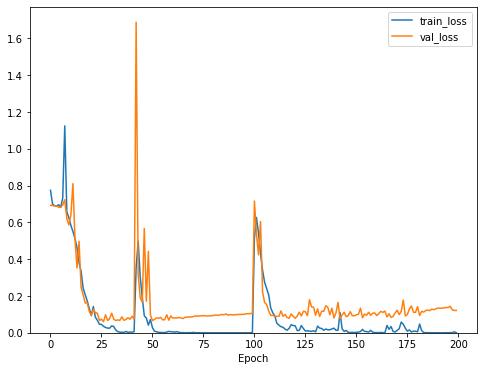

In [26]:
"""plotting loss"""
epochs = [i for i in range(200)]
plt.figure(figsize = (8,6))
loss, = plt.plot(epochs, r.history['loss'])
val_loss,=plt.plot(epochs, r.history['val_loss'])
plt.legend([loss,val_loss], ["train_loss", "val_loss"])
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

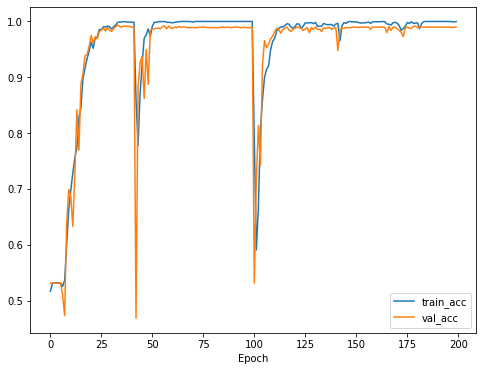

In [27]:
"""plotting accuracy"""
plt.figure(figsize = (8,6))
acc,=plt.plot(epochs, r.history['accuracy'])
val_acc,=plt.plot(epochs, r.history['val_accuracy'])
plt.legend([acc,val_acc], ["train_acc","val_acc"])
plt.xlabel('Epoch')

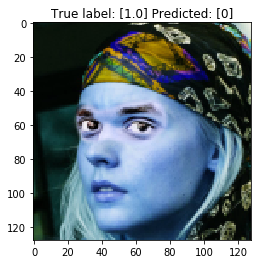

In [28]:
"""plotting random misclassified image"""
p_test = model.predict(X_test).argmax(axis=1)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(X_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % ([y_test[i]], [p_test[i]]));
plt.show()

In [29]:
"""saving the model"""
model.save('vgg_model.h5') 

In [30]:
"""loading the model"""
new_model = tf.keras.models.load_model('vgg_model.h5')

In [31]:
"""test accuracy"""
loss, acc = new_model.evaluate(X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

994/994 - 1s - loss: 0.1213 - accuracy: 0.9899
Restored model, accuracy: 98.99%
